<a href="https://colab.research.google.com/github/ahmetcanerdem/Bil470Proje/blob/master/Transfer%20Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
! pip install  kaggle
import tensorflow as tf
from google.colab import files

from IPython.display import clear_output

### **Aşağıdaki Tüm Kod Veriyi Oluşturma, CNN oluşturma ve callback-treshold parametreleri için en uygun değerleri seçme ve bunların grafiğini çıkarmaya yöneliktir**

In [3]:
#clear_output()
#files.upload()
#!cd drive
#!cd "My Drive"
#!mkdir data
#!cd data
#! mkdir ~/.kaggle
#! cp kaggle.json ~/.kaggle/
#! chmod 600 ~/.kaggle/kaggle.json
#! kaggle datasets list

In [4]:
#! kaggle competitions download -c siim-isic-melanoma-classification
#clear_output()

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
#! mkdir train_t
#! unzip "*.dcm.zip" -d train

#clear_output()

In [7]:
#!pip install pydicom
#import pydicom as dicom
import matplotlib.pyplot as plt
clear_output()

In [8]:
#image_path = './train/ISIC_0015719.dcm'
#ds = dicom.dcmread(image_path)

#plt.imshow(ds.pixel_array)

In [9]:
#ds.PatientID[1:-1]

In [10]:
import os
from PIL import Image
import numpy as np

In [11]:
input_size=(256,256)
test_path=''
test_path='./drive/My Drive/test/'
training_path='./drive/My Drive/train/'
train_0_p=training_path+'train_0/'
train_1_p=training_path+'train_1_large/'
test_0_path= test_path + 'train_0_test/'
test_1_path= test_path + 'train_1_test_large/'
treshold=0.85

In [12]:
DATA=[]
classvector=[]
c=0
first=0;
second=0;
for i in os.listdir(train_0_p):
  clear_output(wait=True)
  print(c)
  c= c+1
  first=first+1;
  path= train_0_p + i
  im=Image.open(path)
  im=im.resize(input_size)
  im=np.array(im)
  im=np.array(im,dtype='float64')
  im = im/255
  DATA.append(im)
  classvector.append(0)
  if(first>500):
    break
  if (c>1000):
    break;
DATA[0]

print("0 verisi bitti, 1 verisi alınıyor")
for i in os.listdir(train_1_p):
  clear_output(wait=True)
  print(c)
  c= c+1
  second=second+1
  path= train_1_p + i
  im=Image.open(path)
  im=im.resize(input_size)
  im=np.array(im)
  im=np.array(im,dtype='float64')
  im = im/255
  DATA.append(im)
  classvector.append(1)
  if(second>500):
    break
  if (c>1000):
    break;
print("Hasta olmayan verilerden :" + str(first) + " kadar alındı")
print("Hasta olan verilerden :" + str(second) + " kadar alındı")

998
Hasta olmayan verilerden :501 kadar alındı
Hasta olan verilerden :498 kadar alındı


In [13]:
DATA=np.reshape(DATA,newshape=(-1,input_size[0],input_size[1],3))

In [14]:
print(len(DATA))
print(len(classvector))


999
999


In [15]:
classvector=np.array(classvector)

### **Bu andan itibaren Transfer Learning modelleri incelenecek**

In [16]:
## Burada devam etmek için Inception v3 ten Transfer Learning uygulayacağım
import os
from tensorflow.keras import layers
from tensorflow.keras import Model

##iv3 ün weight değerleri
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
from tensorflow.keras.applications.inception_v3 import InceptionV3

weight_file= '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'
image_dim=3

--2020-07-24 00:51:34--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.79.128, 108.177.126.128, 108.177.127.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.79.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  84.2MB/s    in 1.0s    

2020-07-24 00:51:35 (84.2 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [17]:
model_I3_trained= InceptionV3(input_shape= (input_size[0], input_size[1],image_dim),
                      include_top= False,
                      weights= None
                      )

model_I3_trained.load_weights(weight_file)

In [18]:
for layer in model_I3_trained.layers:
  layer.trainable= False

In [19]:
model_I3_trained.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [20]:
from tensorflow.keras.optimizers import RMSprop

last_layer= model_I3_trained.get_layer('mixed10')
last_output= last_layer.output

x= layers.Flatten()(last_output)
x= layers.Dense(2048,activation='relu')(x)
x= layers.Dense(1, activation='sigmoid')(x)

In [21]:
model_T= Model(model_I3_trained.input, x)
model_T.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

In [22]:
model_T.fit(DATA, classvector, epochs=50)

Epoch 1/50
32/32 [==============================] - 5s 160ms/step - loss: 3.8956 - acc: 0.5626
Epoch 2/50
32/32 [==============================] - 4s 136ms/step - loss: 0.9671 - acc: 0.6817
Epoch 3/50
32/32 [==============================] - 4s 136ms/step - loss: 0.7992 - acc: 0.7407
Epoch 4/50
32/32 [==============================] - 4s 137ms/step - loss: 0.7571 - acc: 0.7588
Epoch 5/50
32/32 [==============================] - 4s 136ms/step - loss: 0.6186 - acc: 0.8058
Epoch 6/50
32/32 [==============================] - 4s 137ms/step - loss: 0.7032 - acc: 0.7848
Epoch 7/50
32/32 [==============================] - 4s 137ms/step - loss: 0.4833 - acc: 0.8428
Epoch 8/50
32/32 [==============================] - 4s 137ms/step - loss: 0.4565 - acc: 0.8428
Epoch 9/50
32/32 [==============================] - 4s 137ms/step - loss: 0.3851 - acc: 0.8769
Epoch 10/50
32/32 [==============================] - 4s 137ms/step - loss: 0.2067 - acc: 0.9399
Epoch 11/50
32/32 [==============================

In [23]:
DATA_TEST=[]
DATA_TEST_0=[]
DATA_TEST_1=[]
classvector_test=[]
classvector_test_0=[]
classvector_test_1=[]
c=0
first=0;
second=0;
for i in os.listdir(test_0_path):
  clear_output(wait=True)
  print(c)
  c= c+1
  first=first+1;
  path= test_0_path + i
  im=Image.open(path)
  im=im.resize(input_size)
  im=np.array(im)
  im=np.array(im,dtype='float64')
  im = im/255
  DATA_TEST.append(im)
  DATA_TEST_0.append(im)
  classvector_test.append(0)
  classvector_test_0.append(0)
  if(first>100):
    break
  if (c>200):
    break;
DATA[0]

print("0 verisi bitti, 1 verisi alınıyor")
for i in os.listdir(test_1_path):
  clear_output(wait=True)
  print(c)
  c= c+1
  second=second+1
  path= test_1_path + i
  im=Image.open(path)
  im=im.resize(input_size)
  im=np.array(im)
  im=np.array(im,dtype='float64')
  im = im/255
  DATA_TEST.append(im)
  DATA_TEST_1.append(im)
  classvector_test.append(1)
  classvector_test_1.append(1)
  if(second>100):
    break
  if (c>200):
    break;
print("Hasta olmayan verilerden :" + str(first) + " kadar alındı")
print("Hasta olan verilerden :" + str(second) + " kadar alındı")

175
Hasta olmayan verilerden :101 kadar alındı
Hasta olan verilerden :75 kadar alındı


In [24]:
thVector=[];
DATA_TEST= np.array(DATA_TEST).reshape(-1, input_size[0], input_size[1], image_dim)
DATA_TEST_0= np.array(DATA_TEST_0).reshape(-1, input_size[0], input_size[1], image_dim)
DATA_TEST_1= np.array(DATA_TEST_1).reshape(-1, input_size[0], input_size[1], image_dim)
pT= model_T.predict(DATA_TEST)
p0= model_T.predict(DATA_TEST_0)
p1= model_T.predict(DATA_TEST_1)

a_T=[]
a_0=[]
a_1=[]

for tresholdvalue in np.arange(0,1,0.05):
  ##############WHOLE TEST#####################
  vT=[]
  for i in pT:
    if (i>=tresholdvalue):
      vT.append(1)
    else:
      vT.append(0)
  c=0
  for i in range(len(vT)):
    if (vT[i] == classvector_test[i]):
      c = c+1;
  
  a_T.append(c/len(vT))

  ########################################

    ##############TRUE POSITIVE#####################
  v1=[]
  for i in p1:
    if (i>=tresholdvalue):
      v1.append(1)
    else:
      v1.append(0)
  c=0
  for i in range(len(v1)):
    if (v1[i] == classvector_test_1[i]):
      c = c+1;
  
  a_1.append(c/len(v1))

  ########################################

    ##############TRUE NEGATIVE#####################
  v0=[]
  for i in p0:
    if (i>=tresholdvalue):
      v0.append(1)
    else:
      v0.append(0)
  c=0
  for i in range(len(v0)):
    if (v0[i] == classvector_test[i]):
      c = c+1;
  
  a_0.append(c/len(v0))

  ########################################

  thVector.append(tresholdvalue)
    

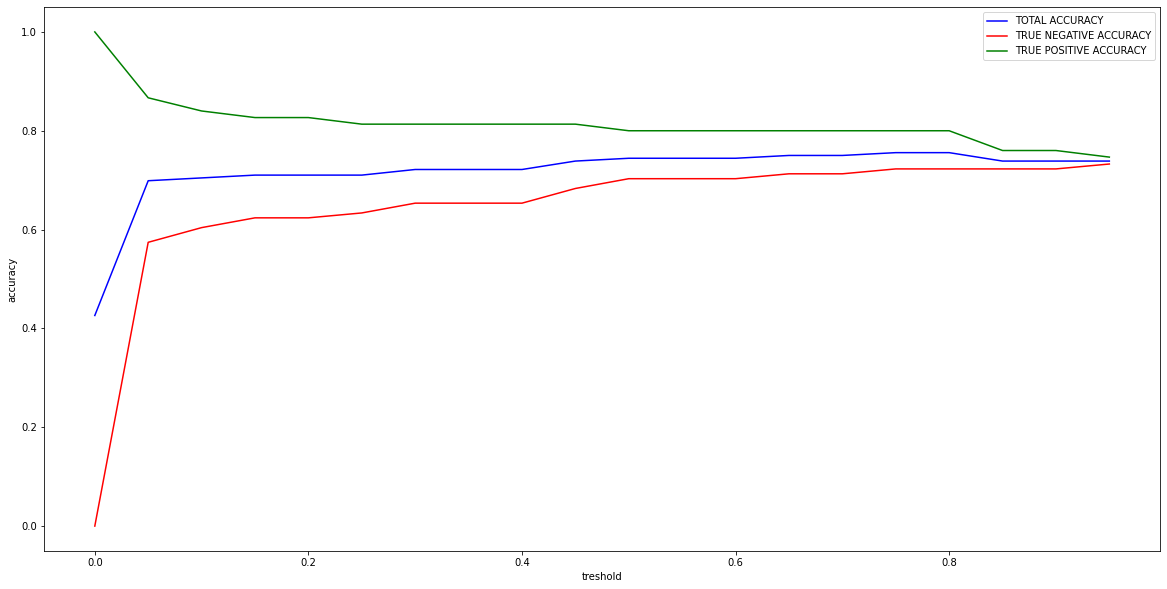

In [25]:
plt.figure(figsize=(20,10))
plt.ylabel('accuracy')
plt.xlabel('treshold')
plt.plot(thVector, a_T, 'b', label='TOTAL ACCURACY')
plt.plot(thVector, a_0, 'r', label='TRUE NEGATIVE ACCURACY')
plt.plot(thVector, a_1, 'g', label='TRUE POSITIVE ACCURACY')
plt.legend()
plt.show()

In [26]:
tresholdvalue=0.55
##############WHOLE TEST#####################
vT=[]
for i in pT:
  if (i>=tresholdvalue):
    vT.append(1)
  else:
     vT.append(0)
c=0
for i in range(len(vT)):
  if (vT[i] == classvector_test[i]):
      c = c+1;
print(str(tresholdvalue)+ "% treshold için isabet değeri:")
print(c/len(vT))

########################################

##############TRUE POSITIVE#####################
v1=[]
for i in p1:
  if (i>=tresholdvalue):
    v1.append(1)
  else:
    v1.append(0)
c=0
for i in range(len(v1)):
  if (v1[i] == classvector_test_1[i]):
    c = c+1;
  
print(str(tresholdvalue)+ "% treshold için TP isabet değeri:")
print(c/len(v1))

  ########################################

    ##############TRUE NEGATIVE#####################
v0=[]
for i in p0:
  if (i>=tresholdvalue):
    v0.append(1)
  else:
    v0.append(0)
c=0
for i in range(len(v0)):
  if (v0[i] == classvector_test[i]):
    c = c+1;
  
print(str(tresholdvalue)+ "% treshold için TN isabet değeri:")
print(c/len(v0))


0.55% treshold için isabet değeri:
0.7443181818181818
0.55% treshold için TP isabet değeri:
0.8
0.55% treshold için TN isabet değeri:
0.7029702970297029


In [27]:
epVector=[];
DATA_TEST= np.array(DATA_TEST).reshape(-1, input_size[0], input_size[1], image_dim)
DATA_TEST_0= np.array(DATA_TEST_0).reshape(-1, input_size[0], input_size[1], image_dim)
DATA_TEST_1= np.array(DATA_TEST_1).reshape(-1, input_size[0], input_size[1], image_dim)

tresholdvalue=0.55

a_T=[]
a_0=[]
a_1=[]

####CREATING MODEL###
x_dummy= layers.Flatten()(last_output)
x_dumy= layers.Dense(2048,activation='relu')(x_dummy)
x_dummy= layers.Dense(1, activation='sigmoid')(x_dummy)

model_dummy= Model(model_I3_trained.input, x_dummy)
model_dummy.compile(optimizer=RMSprop(lr=0.0001), loss='binary_crossentropy', metrics=['acc'])

#model_dummy.fit(DATA, classvector, epochs=epoch_num)



for epoch_num in np.arange(0,250,25):
  ## in each epoch model will be fitted 25 more epochs till 1000 ###

  model_dummy.fit(DATA, classvector, epochs=25)

  
  pT= model_dummy.predict(DATA_TEST)
  p0= model_dummy.predict(DATA_TEST_0)
  p1= model_dummy.predict(DATA_TEST_1)


  ##############WHOLE TEST#####################
  vT=[]
  for i in pT:
    if (i>=tresholdvalue):
      vT.append(1)
    else:
      vT.append(0)
  c=0
  for i in range(len(vT)):
    if (vT[i] == classvector_test[i]):
      c = c+1;
  
  a_T.append(c/len(vT))

  ########################################

    ##############TRUE POSITIVE#####################
  v1=[]
  for i in p1:
    if (i>=tresholdvalue):
      v1.append(1)
    else:
      v1.append(0)
  c=0
  for i in range(len(v1)):
    if (v1[i] == classvector_test_1[i]):
      c = c+1;
  
  a_1.append(c/len(v1))

  ########################################

    ##############TRUE NEGATIVE#####################
  v0=[]
  for i in p0:
    if (i>=tresholdvalue):
      v0.append(1)
    else:
      v0.append(0)
  c=0
  for i in range(len(v0)):
    if (v0[i] == classvector_test[i]):
      c = c+1;
  
  a_0.append(c/len(v0))

  ########################################

  epVector.append(epoch_num)
  print(epoch_num)
    

Epoch 1/25
32/32 [==============================] - 3s 84ms/step - loss: 0.8636 - acc: 0.5916
Epoch 2/25
32/32 [==============================] - 3s 84ms/step - loss: 0.5549 - acc: 0.7187
Epoch 3/25
32/32 [==============================] - 3s 83ms/step - loss: 0.4703 - acc: 0.7738
Epoch 4/25
32/32 [==============================] - 3s 83ms/step - loss: 0.4068 - acc: 0.8008
Epoch 5/25
32/32 [==============================] - 3s 83ms/step - loss: 0.3425 - acc: 0.8438
Epoch 6/25
32/32 [==============================] - 3s 83ms/step - loss: 0.2862 - acc: 0.8709
Epoch 7/25
32/32 [==============================] - 3s 84ms/step - loss: 0.2507 - acc: 0.9029
Epoch 8/25
32/32 [==============================] - 3s 84ms/step - loss: 0.1866 - acc: 0.9419
Epoch 9/25
32/32 [==============================] - 3s 84ms/step - loss: 0.1734 - acc: 0.9459
Epoch 10/25
32/32 [==============================] - 3s 84ms/step - loss: 0.1819 - acc: 0.9349
Epoch 11/25
32/32 [==============================] - 3s 84m

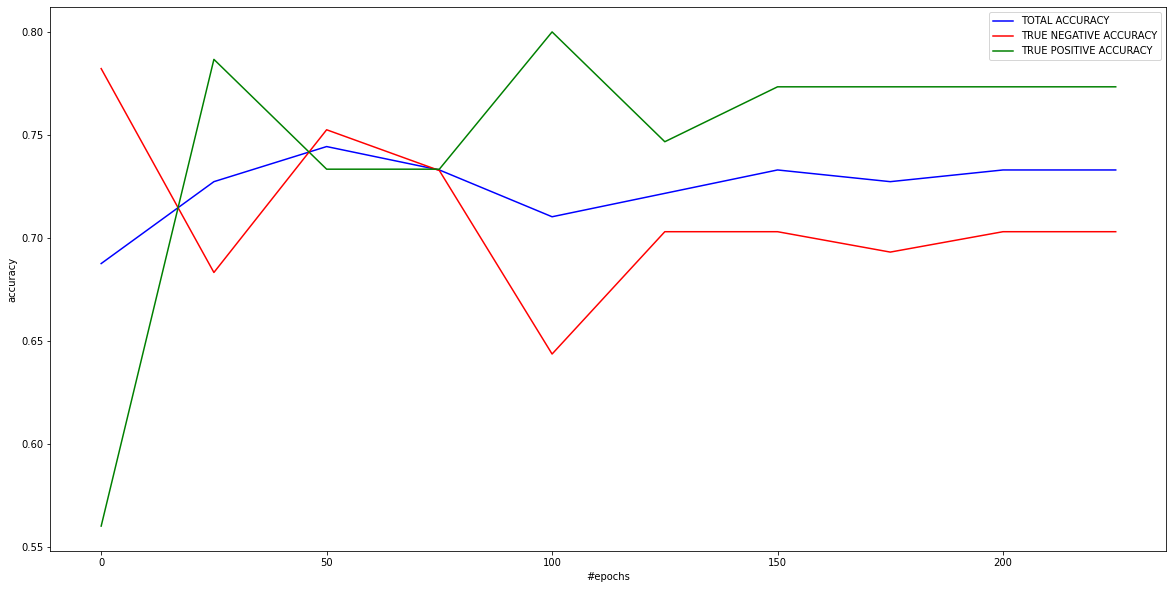

In [28]:
plt.figure(figsize=(20,10))
plt.ylabel('accuracy')
plt.xlabel('#epochs')
plt.plot(epVector, a_T, 'b', label='TOTAL ACCURACY')
plt.plot(epVector, a_0, 'r', label='TRUE NEGATIVE ACCURACY')
plt.plot(epVector, a_1, 'g', label='TRUE POSITIVE ACCURACY')
plt.legend()
plt.show()

In [37]:
tresholdvalue=0.54
##############WHOLE TEST#####################
vT=[]
for i in pT:
  if (i>=tresholdvalue):
    vT.append(1)
  else:
     vT.append(0)
c=0
for i in range(len(vT)):
  if (vT[i] == classvector_test[i]):
      c = c+1;
print(str(tresholdvalue)+ "% treshold için isabet değeri:")
print(c/len(vT))

########################################

##############TRUE POSITIVE#####################
v1=[]
for i in p1:
  if (i>=tresholdvalue):
    v1.append(1)
  else:
    v1.append(0)
c=0
for i in range(len(v1)):
  if (v1[i] == classvector_test_1[i]):
    c = c+1;
  
print(str(tresholdvalue)+ "% treshold için TP isabet değeri:")
print(c/len(v1))

  ########################################

    ##############TRUE NEGATIVE#####################
v0=[]
for i in p0:
  if (i>=tresholdvalue):
    v0.append(1)
  else:
    v0.append(0)
c=0
for i in range(len(v0)):
  if (v0[i] == classvector_test[i]):
    c = c+1;
  
print(str(tresholdvalue)+ "% treshold için TN isabet değeri:")
print(c/len(v0))

0.54% treshold için isabet değeri:
0.7329545454545454
0.54% treshold için TP isabet değeri:
0.7733333333333333
0.54% treshold için TN isabet değeri:
0.7029702970297029
